<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD; 
    color: black;"> <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> AC295: Advanced Practical Data Science </h1>

## Practicum 2: Visual Question Answering

**Harvard University, Fall 2020**  
**Instructors**: Pavlos Protopapas  

### **Team: $\alpha\beta normal$ $Distri\beta ution$**
#### **Roht Beri, Eduardo Peynetti, Jessica Wijaya, Stuart Neilson**

## Creating Pipeline for Training

### Install Packages

In [1]:
!pip3 install transformers

     |████████████████████████████████| 1.3MB 5.7MB/s 
     |████████████████████████████████| 890kB 45.7MB/s 
     |████████████████████████████████| 1.1MB 44.1MB/s 
     |████████████████████████████████| 2.9MB 39.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=c22bb68e157404eb18ee88a396604a239426ec388200355eba15f166a5bfe1ba
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


### Imports

In [2]:
import os
import shutil
import sys
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from transformers import BertTokenizer

### Download Data

In [ ]:
"""
!mkdir 'data'
#shutil.rmtree('/content/data/train2014_tf')
#shutil.rmtree('/content/data/val2014_tf')
!cp -r '/content/drive/My Drive/Practicum2Data/big/val2014_tf' /content/data
!cp -r '/content/drive/My Drive/Practicum2Data/big/train2014_tf' /content/data
!cp -r "/content/drive/My Drive/Practicum2Data/big/answers.csv" /content/data
"""
if not os.path.exists('/content/data'):
    os.mkdir('/content/data')

!gsutil cp -r gs://practicum2-abnormal-distribution/train2014_tf /content/data
!gsutil cp -r gs://practicum2-abnormal-distribution/val2014_tf /content/data

# https://storage.googleapis.com/practicum2-abnormal-distribution/train2014_tf
# https://storage.googleapis.com/practicum2-abnormal-distribution/val2014_tf

Copying gs://practicum2-abnormal-distribution/train2014_tf/vaq_raw_train2014_00-of-10.records...
Copying gs://practicum2-abnormal-distribution/train2014_tf/vaq_raw_train2014_01-of-10.records...
Copying gs://practicum2-abnormal-distribution/train2014_tf/vaq_raw_train2014_02-of-10.records...
Copying gs://practicum2-abnormal-distribution/train2014_tf/vaq_raw_train2014_03-of-10.records...
/ [4 files][  2.4 GiB/  2.4 GiB]   37.0 MiB/s                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://practicum2-abnormal-distribution/train2014_tf/vaq_raw_train2014_04-of-10.records...
Copying gs://practicum2-abnormal-distribution/train2014_tf/vaq_raw_train2014_05-of-10.records...
Copying gs://practicum2-abnormal-distribution/train2014_tf/vaq_raw_train2014_06-of-10

In [3]:
drive.mount('/content/drive', force_remount=False)
if not os.path.exists('/content/data'):
    os.mkdir('/content/data')

!cp -r '/content/drive/My Drive/Practicum2Data/big' /content/data

Mounted at /content/drive


### Utils

In [4]:
# Constants
IMG_WIDTH = 224
IMG_HEIGHT = 224
IMG_CHANNELS = 3

K = 10

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Pipeline variables
batch_size = 64
train_buffer_size = 1000
val_buffer_size = 200
prefetch = AUTOTUNE

In [5]:
# Get Top K answers
def get_top_K_answers(k):
    answers = pd.read_csv("/content/data/big/answers.csv", index_col=0)
    answers = answers.index[:k]
    return list(answers)

In [8]:
# Function to parse data features
def _parse_features_function(example):
    # Parse the input tf.train.Example proto using the dictionary above.
    tf_records_features = {
        'image_raw': tf.io.FixedLenFeature([], tf.string), 
        'question' : tf.io.FixedLenFeature([], tf.string),
        'input_ids': tf.io.FixedLenFeature([], tf.string),
        'token_type_ids': tf.io.FixedLenFeature([], tf.string),
        'attention_mask': tf.io.FixedLenFeature([], tf.string), 
        'answer': tf.io.FixedLenFeature([], tf.string)
    }
    return tf.io.parse_single_example(example, tf_records_features)


# Filter if answer is no
def filter_fn(x):
    #use broadcasting for element-wise tensor operation
    broadcast_equal = tf.equal(TOP_ANSWERS, x['answer'])
    broadcast_equal_int = tf.cast(broadcast_equal, tf.int8)
    broadcast_sum = tf.reduce_sum(broadcast_equal_int)
    return broadcast_sum > 0


# Read image and resize it
def read_and_decode(img):
    img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
    img = tf.cast(img, tf.float32)/255.0
    return img


# Structure the data for training
def structure_data(data):
    image = data['image_raw']
    image = read_and_decode(image)
    
    input_ids = tf.io.decode_raw(data['input_ids'], tf.int32)
    attention_mask = tf.io.decode_raw(data['attention_mask'], tf.int32)
    token_type_ids = tf.io.decode_raw(data['token_type_ids'], tf.int32)
    
    answer = tf.io.decode_raw(data['answer'], tf.int32)

    return ((image, (input_ids, token_type_ids, attention_mask)), answer)


### Build Pipeline

In [9]:
# ############## #
# # Train data # #
# ############## #
tfrecords_pattern_path = "/content/data/big/train2014_tf/vaq_raw_train2014_*-of-*.records"
train_files = tf.io.matching_files(tfrecords_pattern_path)
train_files = tf.random.shuffle(train_files)
train_shards = tf.data.Dataset.from_tensor_slices(train_files)

train = train_shards.interleave(tf.data.TFRecordDataset)
train = train.map(_parse_features_function, num_parallel_calls=AUTOTUNE)
#train = train.filter(filter_fn)
train = train.map(structure_data, num_parallel_calls=AUTOTUNE)
train = train.shuffle(buffer_size=train_buffer_size).batch(batch_size)
train = train.cache().prefetch(prefetch)

# ################### #
# # Validation data # #
# ################### #
tfrecords_pattern_path = "/content/data/big/val2014_tf/vaq_raw_val2014_*-of-*.records"
val_files = tf.io.matching_files(tfrecords_pattern_path)
val_files = tf.random.shuffle(val_files)
val_shards = tf.data.Dataset.from_tensor_slices(val_files)

valid = val_shards.interleave(tf.data.TFRecordDataset)

valid = valid.map(_parse_features_function, num_parallel_calls=AUTOTUNE)
#valid = valid.filter(filter_fn)
valid = valid.map(structure_data, num_parallel_calls=AUTOTUNE)
valid = valid.shuffle(buffer_size=val_buffer_size).batch(batch_size)
valid = valid.cache().prefetch(prefetch)

### Get Top Answers

In [10]:
top_answers = get_top_K_answers(K)
#top_answers = tf.constant(top_answers)

### Test Pipeline

In [11]:
train

<PrefetchDataset shapes: (((None, None, None, 3), ((None, None), (None, None), (None, None))), (None, None)), types: ((tf.float32, (tf.int32, tf.int32, tf.int32)), tf.int32)>

In [12]:
valid

<PrefetchDataset shapes: (((None, None, None, 3), ((None, None), (None, None), (None, None))), (None, None)), types: ((tf.float32, (tf.int32, tf.int32, tf.int32)), tf.int32)>

In [13]:
print(val_files)

tf.Tensor(
[b'/content/data/big/val2014_tf/vaq_raw_val2014_04-of-10.records'
 b'/content/data/big/val2014_tf/vaq_raw_val2014_00-of-10.records'
 b'/content/data/big/val2014_tf/vaq_raw_val2014_03-of-10.records'
 b'/content/data/big/val2014_tf/vaq_raw_val2014_06-of-10.records'
 b'/content/data/big/val2014_tf/vaq_raw_val2014_09-of-10.records'
 b'/content/data/big/val2014_tf/vaq_raw_val2014_02-of-10.records'
 b'/content/data/big/val2014_tf/vaq_raw_val2014_05-of-10.records'
 b'/content/data/big/val2014_tf/vaq_raw_val2014_08-of-10.records'
 b'/content/data/big/val2014_tf/vaq_raw_val2014_01-of-10.records'
 b'/content/data/big/val2014_tf/vaq_raw_val2014_07-of-10.records'
 b'/content/data/big/val2014_tf/vaq_raw_val2014_10-of-10.records'], shape=(11,), dtype=string)


input_ids:  tf.Tensor(
[  101  2054  3609  2003  1996  2795 23095  1029   102     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0], shape=(24,), dtype=int32)

token_type_ids tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(24,), dtype=int32)

attention_mask tf.Tensor([1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(24,), dtype=int32)

answer:  6 : blue



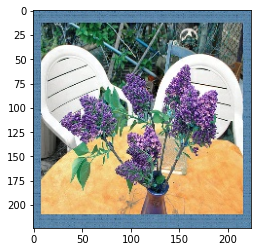

In [15]:
for item in valid.take(1):
    print('input_ids: ',item[0][1][0][0])
    print()
    print('attention_mask', item[0][1][1][0])
    print()
    print('token_type_ids', item[0][1][2][0])
    print()
    print('answer: ', np.argmax(item[1][0]), ':', top_answers[np.argmax(item[1][0])])
    print()
    plt.imshow(item[0][0][0])